In [18]:
#import graph_tool.all as gt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.signal import convolve
import os
import h5py
import functions as fc
import scipy as sp
from tqdm import tqdm
import time
from numba import njit
from IPython.display import clear_output
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [19]:
plt.rcParams['font.size'] = 14
top_dir = os.getcwd()

In [20]:
excluded = [10, 34, 44, 49, 69]
SC = np.load('Data/undirected_terminals_expanded.npy')
SC_truncated = fc.delete(SC, excluded)
FC_empirical = np.load('Results/FC_matrix.npy')
SC_sccm = np.load("Data/null_SC_und_SCCM.npy")
SC_cm = np.load("Data/null_SC_und_CM.npy")

# Simulating FC with Kuramoto model

#### Le modèle de Kuramoto:
$$
\boxed{\dot{\theta}_k = \omega_k + \frac{g}{N} \sum_{j=1}^N \sin \left(\theta_j - \theta_k \right)}, \hspace{12pt} \forall\hspace{6pt} k\in\{1,...,N\}
$$

#### Paramètre d'ordre:
Ce paramètre est analogue à l'excentricité du centre de masse des phases dans leur représentation sur $\mathbb{C}$.
$$
Re^{i\psi(t)} = \frac{1}{N}\sum_{j=1}^N e^{i\theta_j(t)}
$$

#### Cohérence entre phases
On moyenne temporellement la cohérence entre les phases.
$$ C_{i,j} = \frac{1}{\Delta \tau}\left | \int_{\tau}^{\tau+\Delta\tau} e^{i\left [ \theta_i(t) - \theta_j(t) \right ]} dt \right |, $$
où $\theta_i(t)$ correspond à la phase instantanée d'un signal. Cet observable est mis de l'avant (sûrement pas en primeur) dans Schmidt & LaFleur 2015 (https://doi.org/10.1186/s12868-015-0193-z).



In [21]:
@njit
def kuramoto_deriv(t0, X, W, K):
    N = len(X)
    X_dot = []
    for i in range(N):
        x_dot_i = W[i] - 1/N * sum ( [ K[i][j] * np.sin(X[i] - X[j]) for j in range(N) ] )
        X_dot.append( x_dot_i )
    return X_dot

def kuramoto_jacobian(thetas, K):
    N = thetas.shape[0]
    premier_terme = np.diag(np.sin(thetas)) * (K@np.sin(thetas) + K*np.ones((N,1))@np.sin(thetas).T)
    deuxieme_terme = np.diag(np.sin(thetas)) * (K@np.cos(thetas) + K*np.ones((N,1))@np.cos(thetas).T)
    return premier_terme + deuxieme_terme

# Essai du modèle
Cette cellule permet de simuler une seule matrice $\mathrm{FC}_{\mathrm{K}}$ pour un $g$ donné.

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]

0.24521870486223024


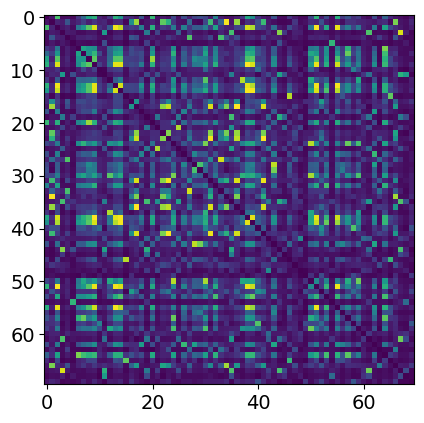

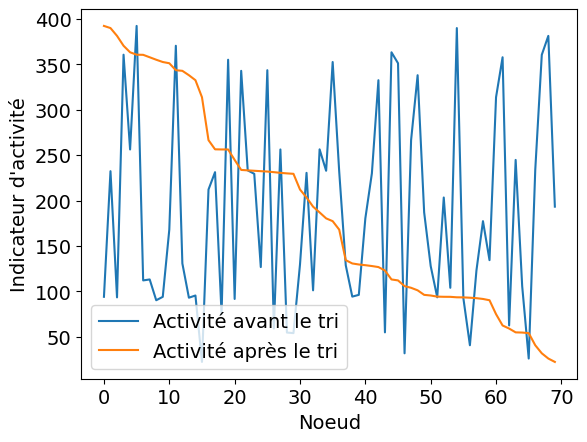

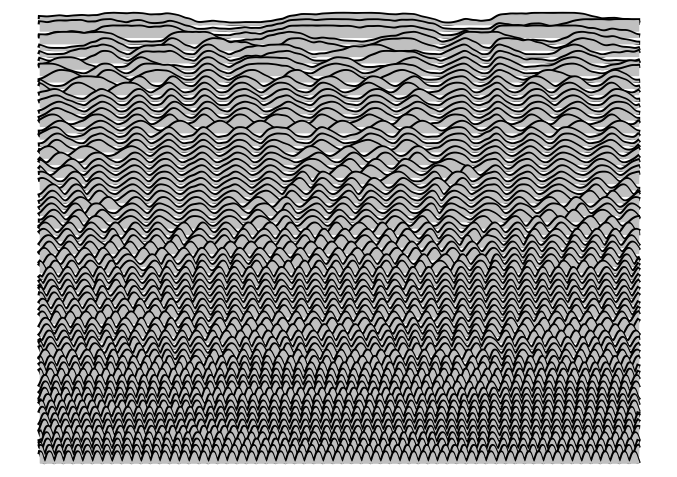

In [17]:
n_oscillators = 70
N_sims = 1
couplage = 2
X_mean = np.pi # Phase initiale moyenne des oscillateurs
X_delta = np.pi # Écart-type (ou rayon) de la distribution des phases initiales
t_i = 0 # Début de l'intervalle de temps
t_f = 200 # Fin de l'intervalle de temps
dt = 0.05
rtol= 1e-10
atol = 1e-12
sim_series_n = 5
#start_cut = 0 # durée à partir de laquelle on calcule les cohérences entre phases
#t_f_vec = np.linspace(20, 250, 10, endpoint=True)
#dt_vec = np.linspace(0.005, 0.25, 10)
#t_f_vec = np.ones(2)*80#np.linspace(20, 250, 10, endpoint=True)

t_vec = np.linspace(t_i, t_f,int((t_f-t_i)/dt),endpoint=True)
correls = []
FC_sim_stack = []
for i in tqdm(range(N_sims)):
    #----------
    X = np.random.uniform(X_mean-X_delta, X_mean+X_delta, size=n_oscillators)
    W = np.random.uniform(0,2, size=n_oscillators)
    K = couplage*SC # On injecte le SC
    #-----On intègre le modèle-----
    solution = sp.integrate.solve_ivp(kuramoto_deriv, t_span=(t_i,t_f), y0=X, args=(W,K),atol=atol, rtol=rtol, method="RK45")
    x_sol = solution.y
    t_sol = solution.t # Vecteur de temps lors duquel la fonction est évaluée
    #t_sol_threshold_bin = t_sol<start_cut
    #start_id = np.where(t_sol_threshold_bin == False)[0][0]
    FC_coh_unique = fc.compute_phase_coherence_matrix(x_sol[:,0:])
    FC_sim_stack.append(FC_coh_unique)

FC_mean = np.mean(FC_sim_stack,axis=0)
print(fc.correlate_matrices(SC_truncated, fc.delete(FC_mean,excluded)))
plt.imshow(FC_mean)
plt.show()

save_ts = False

echant_ts = np.copy(x_sol)
activities = np.sum(np.abs(np.diff(echant_ts, axis=1)), axis=1)
sorted_indices = np.flip(np.argsort(activities))
sorted_ts = echant_ts[sorted_indices,:]
plt.plot(activities, label="Activité avant le tri")
plt.xlabel("Noeud")
plt.ylabel("Indicateur d'activité")
plt.plot(np.sum(np.abs(np.diff(sorted_ts, axis=1)), axis=1), label="Activité après le tri")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
for i,x in enumerate(sorted_ts):
    actual_ts = np.sin(x[0:])+i*1.3
    plt.plot(t_sol, actual_ts, zorder=len(sorted_ts)-i, linewidth=3,color="black")
    plt.fill_between(t_sol, -np.ones(actual_ts.shape[0]) -0.1 + i*1.3, actual_ts,zorder=len(sorted_ts)-i, color="silver", alpha=1)
plt.ylim(np.min(np.sin(sorted_ts))-1,np.max(actual_ts)+1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)         
for pos in ['right', 'top', "bottom", 'left']: 
   plt.gca().spines[pos].set_visible(False) 
#plt.xlabel(r"$t$")
plt.tight_layout()
#plt.savefig("kuramoto_timeseries_plot.pdf")
plt.show()

if save_ts:
    np.save("kuramoto_timeseries.npy", sorted_ts)

### Visualisation

Triage des séries selon la grandeur de leur indicateur d'activité (le même que celui pour le critère d'arrêt dans le modèle de RNN)

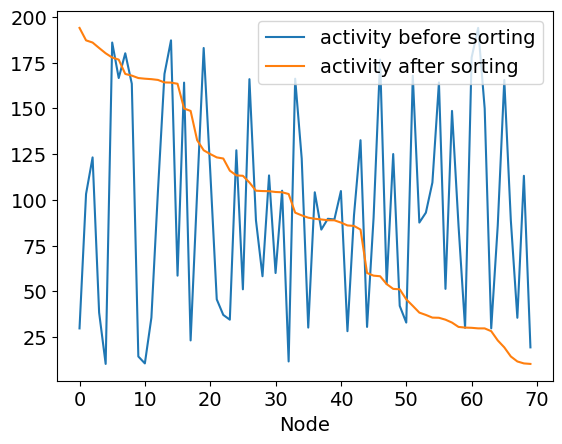

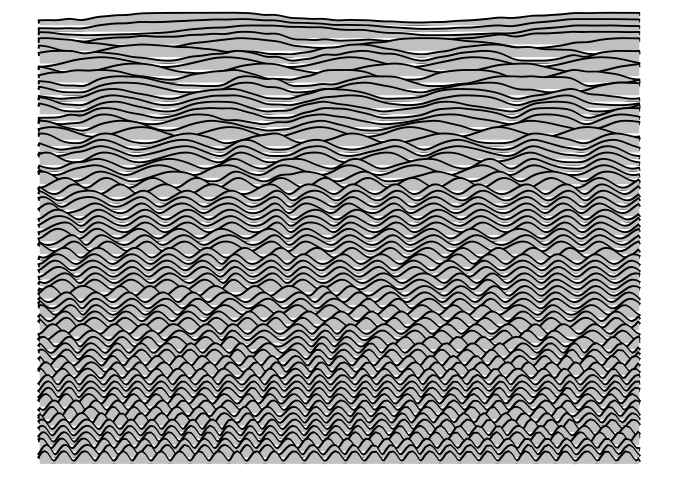

In [7]:
save_ts = False

echant_ts = np.copy(x_sol)
activities = np.sum(np.abs(np.diff(echant_ts, axis=1)), axis=1)
sorted_indices = np.flip(np.argsort(activities))
sorted_ts = echant_ts[sorted_indices,:]
plt.plot(activities, label="Activité avant le tri")
plt.xlabel("Noeud")
plt.ylabel("Indicateur d'activité")
plt.plot(np.sum(np.abs(np.diff(sorted_ts, axis=1)), axis=1), label="Activité après le tri")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
for i,x in enumerate(sorted_ts):
    actual_ts = np.sin(x[0:])+i*1.3
    plt.plot(t_sol, actual_ts, zorder=len(sorted_ts)-i, linewidth=3,color="black")
    plt.fill_between(t_sol, -np.ones(actual_ts.shape[0]) -0.1 + i*1.3, actual_ts,zorder=len(sorted_ts)-i, color="silver", alpha=1)
plt.ylim(np.min(np.sin(sorted_ts))-1,np.max(actual_ts)+1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)         
for pos in ['right', 'top', "bottom", 'left']: 
   plt.gca().spines[pos].set_visible(False) 
#plt.xlabel(r"$t$")
plt.tight_layout()
#plt.savefig("kuramoto_timeseries_plot.pdf")
plt.show()

if save_ts:
    np.save("kuramoto_timeseries.npy", sorted_ts)

Trier les clusters en ordre croissant de leur écart-type moyen. De cette manière, il y a gradation de l'activité.

# Comparaison des deux méthodes de calcul de FC simulés

In [7]:
begin_time = time.time()
FC_essai_cor = fc.compute_correlation_matrix(np.sin(x_sol))
compute_time_cor = time.time()-begin_time
print("Correlation matrix : " + str(np.round(compute_time_cor, 2)) + " s")
begin_time = time.time()
FC_essai_coh = fc.compute_phase_coherence_matrix(x_sol)
compute_time_coh = time.time()-begin_time
print("Coherence matrix : " + str(np.round(compute_time_coh, 2)) + " s")
print("Corrélation du FC coh. VS corr. : ", fc.correlate_matrices(fc.delete(FC_essai_coh, excluded), FC_empirical),fc.correlate_matrices(fc.delete(FC_essai_cor, excluded), FC_empirical))


/home/arleg/Documents/CERVO/projetRNN/fC_sim/functions.py:168: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  matrix[i, j] = np.arctanh(np.corrcoef(timeseries[i], timeseries[j])[0, 1])


Correlation matrix : 3.95 s
Coherence matrix : 0.2 s
Corrélation du FC coh. VS corr. :  0.23528721532085298 0.07853923273386595


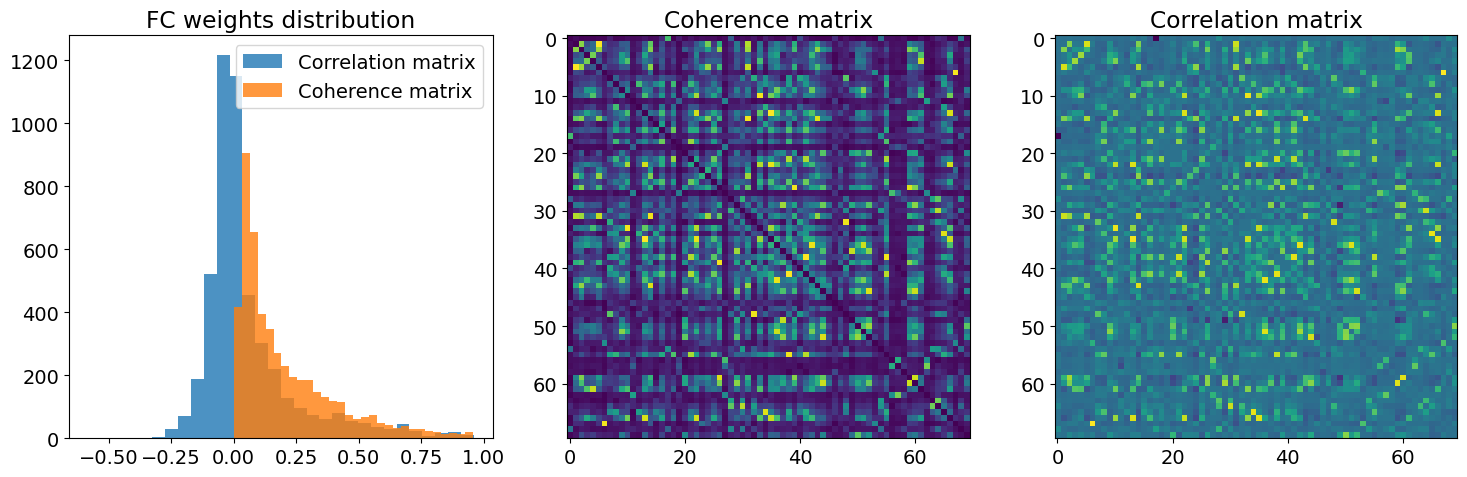

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,5), tight_layout=True)
ax[0].hist(FC_essai_cor.flatten(), bins=30, label="Correlation matrix", alpha=0.8)
ax[0].hist(FC_essai_coh.flatten(), bins=30, label="Coherence matrix", alpha=0.8)
ax[0].title.set_text("FC weights distribution")
ax[0].legend()
ax[1].imshow(FC_essai_coh)
ax[1].title.set_text("Coherence matrix")
ax[2].imshow(FC_essai_cor)
ax[2].title.set_text("Correlation matrix")
plt.show()

Ceci montre que des deux méthodes de calcul d'une matrice contenant les indices de similarité entre séries $i$ et $j$, seule la matrice de cohérence présente des valeurs confinées à l'intervalle $[0,\;1]$.

# Running multiple simulations
Cette première cellule contient les paramètres de la série de simulations à lancer.

Couplages balayés :  [0.0, 0.1724, 0.3448, 0.5172, 0.6897, 0.8621, 1.0345, 1.2069, 1.3793, 1.5517, 1.7241, 1.8966, 2.069, 2.2414, 2.4138, 2.5862, 2.7586, 2.931, 3.1034, 3.2759, 3.4483, 3.6207, 3.7931, 3.9655, 4.1379, 4.3103, 4.4828, 4.6552, 4.8276, 5.0]
Bornes de la distribution statique des fréquences naturelles :  [0, 2]


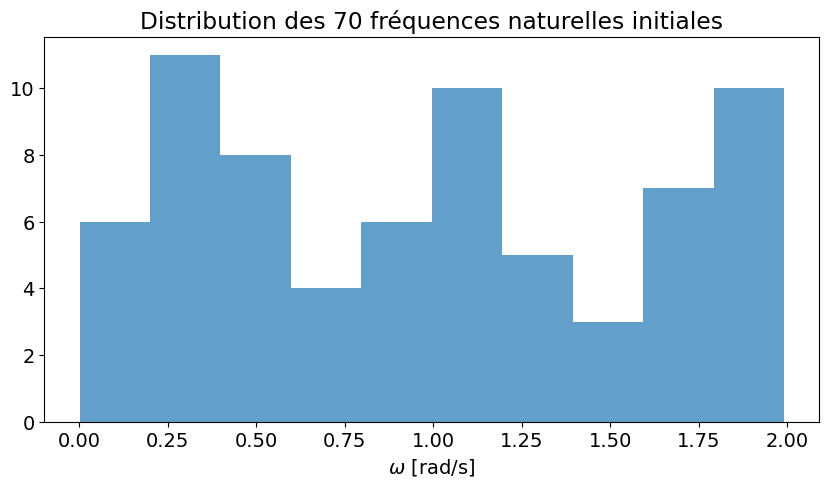

In [15]:
# Nombre de simulations par configuration
N_sim = 50

# Nombre de noeuds (on en exclut 5 par après)
nodes_n = 70

# Temps
t_end = 100 
dt = 0.01 # on se permet de fixer un pas de temps avec ce modèle, puisque les séries temporelles ne sont pas volatiles du tout
t_vec = np.linspace(0, t_end, int(t_end/dt))
t_i = t_vec[0]
t_f = t_vec[-1]

# Couplage
K_vec = np.round(np.linspace(0,5, 30, endpoint=True), 4)
print("Couplages balayés : ", list(K_vec))

# Initialisation des fréquences propres
omega_mean = 1
omega_min = 0.2
omega_max = 2.0
omega_unif = False
omega_unif_fixedCtr = False
omega_unif_max = False
omega_normal = False
omega_ponctual  = False
omega_ponctual_min = 0.1
omega_ponctual_max = 1.9
omega_fixedCtr = 1
omega_maxR = 1

omega_static = True # C'est ici qu'on initialise les fréquences propres des oscillateurs. On spécifie l'intervalle de distribution uniforme plus bas.
omega_static_interv = [0,2]

omega_sweep_n = 30

# Sweep des CI à la place
CI_sweep = False
CI_sweep_n = 10

# Type de FC
phase_coherence = True # Par défaut : matrice de corrélation du sinus des phases

# Aucun balayage, on ne fait que plusieurs paquets de simulations pour une même configuration de couplage (et distribution fréquentielle constante)
if omega_static:
    omega_center_vec = np.ones(omega_sweep_n)*(omega_static_interv[1]-omega_static_interv[0])/2
    omega_radius_vec = np.copy(omega_center_vec)
    
# Balayage de l'écart-type, valeur centrale fixe
if omega_normal:
    omega_std_vec = np.round(np.linspace(0, 0.5, omega_sweep_n, endpoint=True), 4)
    #print("Centre de distribution des fréquences naturelles", omega_radius_vec)

# Balayage de la valeur centrale (de la valeur max à sa moitié) et du rayon de la distribution uniforme (majoration par valeur max)
if omega_unif and not omega_unif_fixedCtr and not omega_unif_max:
    omega_center_vec = np.round(np.linspace(omega_max, (omega_max-omega_min)/2, omega_sweep_n, endpoint=True), 4)
    omega_radius_vec = np.round(np.linspace(0, (omega_max-omega_min)/2, omega_sweep_n, endpoint=True), 4)
    print("Rayon de distribution des fréquences naturelles", omega_radius_vec)
if omega_unif and not omega_unif_fixedCtr and omega_unif_max:
    omega_center_vec = np.round(np.linspace( omega_min/2 , omega_max/2, omega_sweep_n), 4)
    omega_radius_vec = np.round(np.linspace(omega_center_vec[0], omega_max/2, omega_sweep_n, endpoint=True), 4)
    print("Max de distribution des fréquences naturelles", omega_center_vec + omega_radius_vec)
    print("Rayon de distribution des fréquences naturelles", omega_radius_vec)
if omega_unif and omega_unif_fixedCtr and not omega_unif_max:
    omega_center_vec = np.round(np.linspace(omega_fixedCtr, omega_fixedCtr, omega_sweep_n, endpoint=True), 4)
    omega_radius_vec = np.round(np.linspace(0, omega_maxR, omega_sweep_n, endpoint=True), 4)
    print("Rayon de distribution des fréquences naturelles", omega_radius_vec)
if omega_ponctual:
    omega_center_vec = np.round(np.linspace(omega_ponctual_min, omega_ponctual_max, omega_sweep_n, endpoint=True), 4)
    omega_radius_vec = np.zeros(omega_sweep_n)
    print("Centre de distribution des fréquences naturelles", omega_center_vec)
if omega_static:
    print("Bornes de la distribution statique des fréquences naturelles : ", omega_static_interv)
    
# Affichage de la distribution des fréquences naturelles
plt.figure(figsize=(10,5))
colors_list = fc.colors(len(omega_center_vec))

for i in range(omega_sweep_n):
    if omega_unif or omega_ponctual or omega_static:
        omega_vec = np.random.uniform(omega_center_vec[i]-omega_radius_vec[i], omega_center_vec[i]+omega_radius_vec[i], nodes_n)
    elif omega_normal:
        omega_vec = np.abs(np.random.normal(omega_mean, omega_std_vec[i], nodes_n))

    if i == omega_sweep_n-5:   
        plt.title(f"Distribution des {nodes_n} fréquences naturelles initiales")
        plt.hist(omega_vec, alpha=0.7)#,color=colors_list[i])
        plt.xlabel("$\omega$ [rad/s]")
plt.show()

In [21]:
sim_id = len(fc.identify_files(top_dir+"/Data/sims", keywords=["kuramoto"]))
sim_folder = top_dir + "/Data/sims/" + "kuramoto_sim_{}".format(sim_id)
fc.create_folder(sim_folder)

for j in range(omega_sweep_n):
    sims_dict = {} # On réinitialise le dictionnaire qui contient les informations de la simulation
    sims_dict["omega_unif"] = omega_unif # Type de distribution des fréquences naturelles
    sims_dict["omega_unif_max"] = omega_unif_max
    sims_dict["omega_ponct"] = omega_ponctual # Type de distribution des fréquences naturelles
    sims_dict["omega_unif_fixC"] = omega_unif_fixedCtr # Type de distribution des fréquences naturelles
    sims_dict["omega_norm"] = omega_normal
    sims_dict["omega_static"] = omega_static

    if omega_normal:
        sims_dict["omega_std"] = omega_std_vec[j] # Écart-type de la distribution de fréquences naturelles
        sims_dict["omega_ctr"] = omega_mean # Valeur centrale de la distribution de fréquences naturelles
    elif omega_unif or omega_ponctual or omega_unif_max or omega_static:
        sims_dict["omega_r"] = omega_radius_vec[j] # Rayon de la distribution
        sims_dict["omega_ctr"] = omega_center_vec[j] # Valeur centrale de la distribution de fréquences naturelles

    sims_dict["info"] = "Coherence FC : " + str(phase_coherence)
    sims_dict["K"] = K_vec # Valeurs de couplage balayés
    sims_dict["order"] = [] # Série temporelle du paramètre d'ordre (N séries opérant sur les n noeuds)
    sims_dict["FC"] = [] # FC simulé
    sims_dict["omega"] = [] # Distribution aléatoire des fréquences naturelles
    sims_dict["dt"] = dt # Pas de temps d'intégration numérique
    sims_dict["t"] = (t_i, t_f) # Intervalle de temps
    for K_ in K_vec:

        FCsim_stack = []
        omegas_stack = []
        orders_stack = []
    
        for i in tqdm(range(N_sim)):
            
            K = K_ * SC # On injecte "à sec" le SC dans la matrice de couplage
            
            if omega_normal: # réinitialisation des fréquences naturelles
                W = np.abs(np.random.normal(sims_dict["omega_ctr"], sims_dict["omega_std"], nodes_n))
            else:
                W = np.random.uniform(sims_dict["omega_ctr"]-sims_dict["omega_r"], sims_dict["omega_ctr"]+sims_dict["omega_r"], nodes_n)

            omegas_stack.append(W)
            
            X_initial = np.random.uniform(0, 2*np.pi, nodes_n) # réinitialisation des phases de départ
            solution = sp.integrate.solve_ivp(kuramoto_deriv, t_span=(t_i,t_f), y0=X_initial, t_eval=t_vec, args=(W,K)).y

            # On génère une FC synthétique
            if phase_coherence:
                FC_sim = fc.compute_phase_coherence_matrix(solution)
            else:
                sin_series = np.sin(solution) # TR : fonction sinus
                FC_sim = fc.compute_correlation_matrix(sin_series)
                
            FCsim_stack.append(FC_sim)

            # On calcule la série temporelle du paramètre d'ordre
            order = fc.compute_order(solution, last_only=True) 
            orders_stack.append(order)
    
        # Ajout au dictionnaire
        sims_dict["omega"].append(omegas_stack)
        sims_dict["FC"].append(FCsim_stack)
        sims_dict["order"].append(orders_stack)
    
    # Enregistrement des données sous forme de dictionnaire
    sim_iteration = len(fc.identify_files(sim_folder, keywords=["kuramoto"]))
    if omega_unif or omega_ponctual or omega_static:
        fc.save_hdf5(sim_folder +"/{}_".format(fc.fill_index(sim_iteration)) + "kuramoto_wR={}.hdf5".format(str(sims_dict["omega_r"]).replace(".", "_")), sims_dict)
        clear_output(wait=True)
        print("Enregistrement pour wR={}".format(str(sims_dict["omega_r"]).replace(".", "_")) )
    elif omega_normal:
        fc.save_hdf5(sim_folder +"/{}_".format(fc.fill_index(sim_iteration)) + "kuramoto_wStd={}.hdf5".format(str(sims_dict["omega_std"]).replace(".", "_")), sims_dict)
        clear_output(wait=True)
        print("Enregistrement pour wStd={}".format(str(sims_dict["omega_std"]).replace(".", "_")) )


Enregistrement pour wR=1_0


# Analysis
On importe la série de simulations en spécifiant le numéro qui lui a été attribué lors de l'enregistrement (le numéro dans le nom du dossier la contenant).

In [22]:
sim_id = 24
short_data = True
if not short_data:
    sim_folder = top_dir + "/Data/sims/" + "kuramoto_sim{}".format(sim_id)
else:
    sim_folder = top_dir + "/Data/sims/" + "kuramoto_sim{}_short".format(sim_id)

print(sim_folder)

/home/arleg/Documents/CERVO/projetRNN/fC_sim/Data/sims/kuramoto_sim24_short


In [23]:
# On importe les données de la simulation
data_files = fc.identify_files(sim_folder, keywords="hdf5")
data_files = sorted(data_files)

data = []
for data_file in tqdm(data_files):
    data.append(fc.load_hdf5(sim_folder+"/"+data_file))

print(data[0].keys())

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 140.30it/s]

dict_keys(['FC', 'K', 'dt', 'info', 'omega', 'omega_ctr', 'omega_norm', 'omega_ponct', 'omega_r', 'omega_static', 'omega_unif', 'omega_unif_fixC', 'omega_unif_max', 'order', 't'])


In [24]:
K_vec = data[0]["K"] # x-axis for grid search
print("Valeurs de couplage balayées : ", K_vec)

print(str(data[0]["info"])[2:-1])
try:
    print("Type de distribution fréquentielle : ")
    print("     bornes fixes = "+ ("Oui" if data[0]["omega_static"] else "Non" ))
    print("     uniforme = "+ ("Oui" if data[0]["omega_unif"] else "Non" ))
    print("     borne supérieure mobile = "+ ("Oui" if data[0]["omega_unif_max"] else "Non" ))
    print("     uniforme à centre fixe = "+ ("Oui" if data[0]["omega_unif_fixC"] else "Non" ))
    print("     ponctuelle = "+ ("Oui" if data[0]["omega_ponct"] else "Non"))
    print("     normale = "+ ("Oui" if data[0]["omega_norm"] else "Non"))
    wR_vec = np.array([ data[i]["omega_r"] for i in range(len(data_files))]) # y-axis for grid search
    print("Rayons de distribution fréquentielle balayés : ", wR_vec)
    print("Pas de temps : dt = " + str(data[0]["dt"]))
    print("Durée de simulation : dt = " + str(data[0]["t"]))
except:
    print("vielle simulation")

Valeurs de couplage balayées :  [0.     0.1724 0.3448 0.5172 0.6897 0.8621 1.0345 1.2069 1.3793 1.5517
 1.7241 1.8966 2.069  2.2414 2.4138 2.5862 2.7586 2.931  3.1034 3.2759
 3.4483 3.6207 3.7931 3.9655 4.1379 4.3103 4.4828 4.6552 4.8276 5.    ]
Coherence FC : True
Type de distribution fréquentielle : 
     bornes fixes = Oui
     uniforme = Non
     borne supérieure mobile = Non
     uniforme à centre fixe = Non
     ponctuelle = Non
     normale = Non
Rayons de distribution fréquentielle balayés :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
Pas de temps : dt = 0.01
Durée de simulation : dt = [  0. 100.]


100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 11.72it/s]


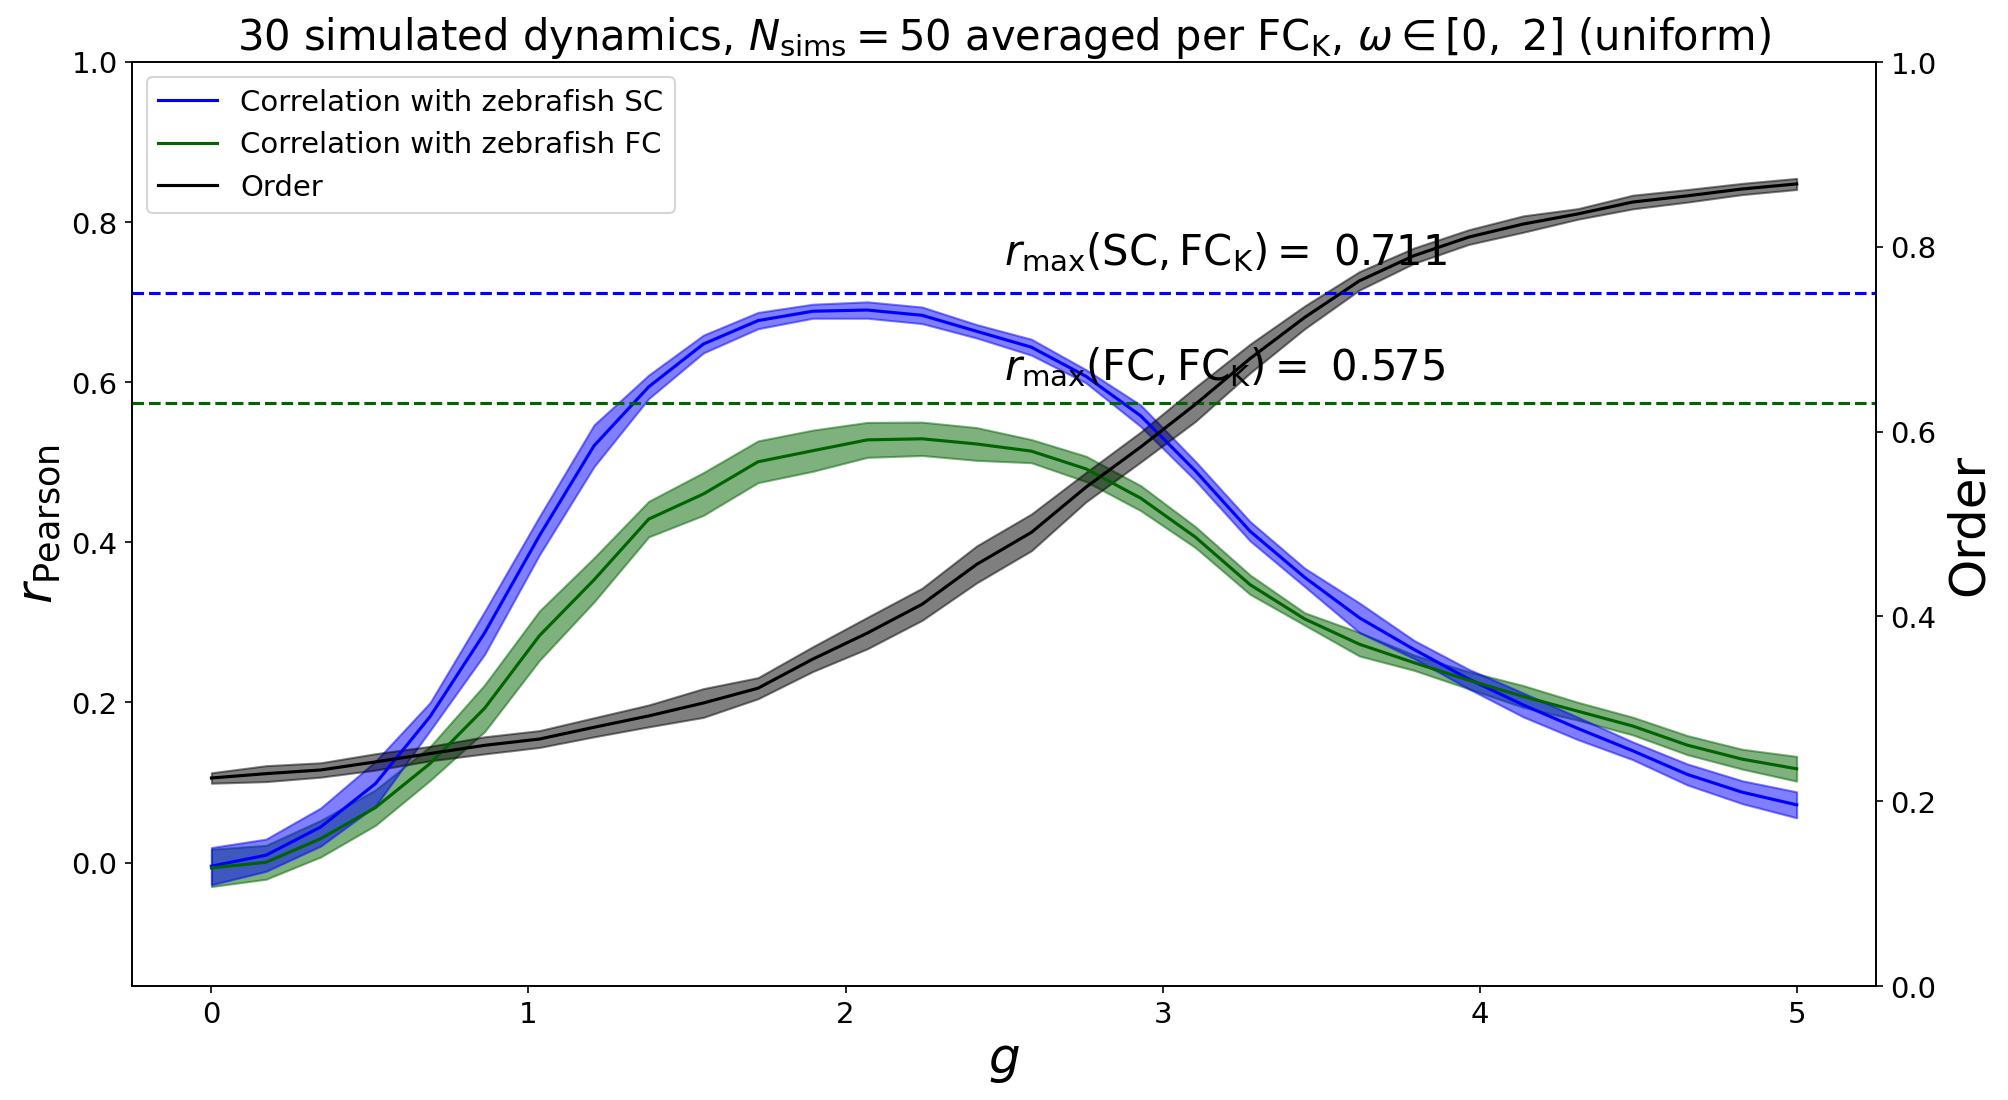

In [25]:
save = False

r_values_stack = []
r_values_SC_stack = []
sigm_x0_stack = []
FC_mean_stack = []
mean_order_stack = []

fig,ax = plt.subplots(1,1, figsize=(15,8), dpi=150)

max_order = 1 #np.max([np.mean(data[0]["order"], axis=1)[:,-1] for i in range(wR_vec.shape[0])])


# Affichage de la corrélation selon le couplage pour chaque type de distribution fréquentielle
title = str(len(data_files)) + " simulated dynamics, "  + r"$N_{\mathrm{sims}} =$" + str(data[0]["order"].shape[1]) + r" averaged per $\mathrm{FC}_{\mathrm{K}} $, " + r"$ \omega\in [$" 
radius = data[0]["omega_r"]
ctr = data[0]["omega_ctr"]
title +=  str(round(ctr-radius))  +"$,$ "+ str(round(ctr+radius))+"$]$ (uniform)" 

ax.set_title(title, fontsize=20)
ax.set_xlabel(r"$g$", fontsize=24)
ax.set_ylabel(r"$r_{\mathrm{Pearson}}$", color="black", fontsize=24)#\left( \mathrm{FC}/\mathrm{SC}, \mathrm{FC}_{\mathrm{K}} \right)$", color="black", fontsize=24)
ax2 = ax.twinx()
ax2.set_ylabel("Order", color="black", fontsize=24)
#ax2.set_ylabel(r"$|\langle R_{f} \rangle_N|$", color="black")
ax2.set_ylim(0,max_order)

for i in tqdm(range(len(data_files))):
    #Calcul des matrices FC moyennes pour les N simulations
    if short_data:
        mean_FC = data[i]['FC']
    else:
        mean_FC = np.mean(data[i]["FC"],axis=1)
    FC_mean_stack.append(mean_FC)
    try :
        mean_order = np.mean(data[i]["order"], axis=1)[:]
    except:
        mean_order = np.mean(data[i]["order"], axis=1)[:,-1] # On va chercher la dernière valeur d'ordre des séries temporelles

    mean_order_stack.append(mean_order)
    r_values = ([fc.correlate_matrices(fc.delete(mean_FC[j],excluded), FC_empirical, choice=False) for j in range(K_vec.shape[0]) ])
    r_values_SC = ([fc.correlate_matrices(fc.delete(mean_FC[j],excluded), SC_truncated, choice=False) for j in range(K_vec.shape[0]) ])
    r_values_stack.append(r_values)
    r_values_SC_stack.append(r_values_SC)

ax.plot(K_vec, np.mean(r_values_SC_stack, axis=0), color="blue",label="Correlation with zebrafish SC")
ax.plot(K_vec, np.mean(r_values_stack, axis=0), color="darkGreen", label="Correlation with zebrafish FC")


r_std = np.std(r_values_stack,axis=0)
ax.fill_between(K_vec, np.mean(r_values_stack, axis=0)-r_std, np.mean(r_values_stack, axis=0)+r_std, color="darkGreen", alpha=0.5)

r_std_SC = np.std(r_values_SC_stack,axis=0)
ax.fill_between(K_vec, np.mean(r_values_SC_stack, axis=0)-r_std_SC, np.mean(r_values_SC_stack, axis=0)+r_std_SC, color="blue", alpha=0.5)

# Affichage du paramètre d'ordre moyen des N sims pour chaque configuration

order_std=np.std(mean_order_stack, axis=0)

ax.axhline(np.max(r_values_stack), linestyle="--", color="darkGreen")
ax.fill_between(K_vec, np.mean(mean_order_stack,axis=0)-order_std, np.mean(mean_order_stack,axis=0)+order_std, color="black", alpha=0.5)
ax.plot(K_vec, np.mean(mean_order_stack,axis=0), color="black", alpha=1, label="Order")

ax.text(np.max(K_vec)/2, np.max(r_values_stack)*1.05, r"$r_{\mathrm{max}}\left (\mathrm{FC}, \mathrm{FC}_{\mathrm{K}} \right ) =$ "+str(np.round(np.max(r_values_stack),3)), fontsize=20)

ax.axhline(np.max(r_values_SC_stack), linestyle="--", color="blue")
ax.text(np.max(K_vec)/2, np.max(r_values_SC_stack)*1.05, r"$r_{\mathrm{max}} \left (\mathrm{SC},\mathrm{FC}_{\mathrm{K}} \right) =$ "+str(np.round(np.max(r_values_SC_stack),3)), fontsize=20)
#ax.set_xlim(0,10)
ax.set_ylim(np.min([np.min(r_values_stack), np.min(r_values_SC_stack)])-0.1,1)
ax.legend()#loc=(0.01,0.01), fontsize=18)

if save:
    print("Saving : "+ "Data/kuramoto_sim{}".format(sim_id) + "_maxCorr={}.pdf".format(np.round(np.max(r_values_stack),2)))
    plt.savefig("Data/kuramoto_sim{}".format(sim_id) + "_simplif_maxCorr={}.pdf".format(np.round(np.max(r_values_stack),2)))
    plt.savefig("Data/kuramoto_sim{}".format(sim_id) + "_simplif_maxCorr={}.png".format(np.round(np.max(r_values_stack),2)))

plt.show()

## Searching for best configuration
### SC vs FC_K

In [30]:
save_FC_optimal = True

rVal = np.asarray(r_values_SC_stack)
max_K_id = np.argmax(rVal) % rVal.shape[1]
max_w_id = np.argmax(rVal) // rVal.shape[1]
print("Corrélation maximale avec FC : ", rVal[max_w_id,max_K_id])
print( "Couplage : ", K_vec[max_K_id] )

# On va chercher la meilleure configuration au moyen de argmax en se basant sur les corrélations de Pearson avec la matrice moyennée
FC_simulated = FC_mean_stack[max_w_id][max_K_id]

if save_FC_optimal:
    np.save("kuramoto_FCsim.npy", FC_simulated)


Corrélation maximale avec FC :  0.7110130437213436
Couplage :  2.069


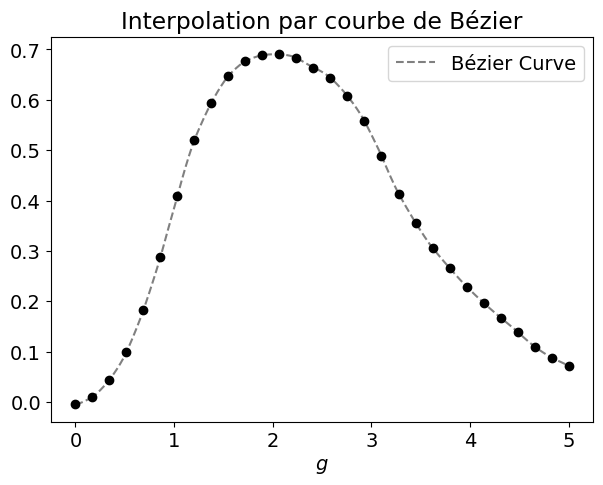

In [27]:
scatter_x = K_vec
scatter_y = np.mean(r_values_SC_stack,axis=0)
points = np.column_stack((scatter_x, scatter_y))

n_points = len(points)
curves = []
# Premier segment
p0, p1 = points[0], points[1]
p2, p3 = fc.get_control_points(points[0], points[1], points[2])
curves.append(fc.bezier_curve(p0, p2, p3, p1, n_points = 1000))

# Segments intermédiaires
for i in range(1, n_points - 2):
    p0, p1 = points[i], points[i + 1]
    p2_prev, p3_prev = curves[-1][-2], curves[-1][-1]
    p2, p3 = fc.get_control_points(points[i], points[i + 1], points[i + 2])
    curves.append(fc.bezier_curve(p0, p2_prev, p2, p1))

# Dernier segment
p0, p1 = points[-2], points[-1]
p2_prev, p3_prev = curves[-1][-2], curves[-1][-1]
curves.append(fc.bezier_curve(p0, p2_prev, p3_prev, p1))

# Concaténation des segments
bezier_points = np.vstack(curves)

plt.figure(figsize=(7,5))
plt.scatter(scatter_x, scatter_y, color='black')
plt.plot(bezier_points[:, 0], bezier_points[:, 1], zorder=0,color='gray', linestyle="--", label='Bézier Curve')
plt.legend()
plt.xlabel(r'$g$')
plt.title('Interpolation par courbe de Bézier')
plt.show()


In [28]:
# Fit de la Bézier pour obtention du maximum

bezier_max_K_id = np.argmax(bezier_points[:, 1])
print("Couplage de corrélation maximale déduit par ajustement de courbes de Bézier quadratiques :", bezier_points[bezier_max_K_id, 0])
SC_FC_optimal_K = bezier_points[bezier_max_K_id, 0]
# Fit d'un polynome là-dessus pis obtention du maximum [déclassé]
#start_i = 4
#end_i = 20

#max_polyfit = fc.polyfit_maximum(K_vec[start_i:end_i], np.mean(r_values_SC_stack, axis=0)[start_i:end_i], res_factor=20, deg=5, show=True)[0]
#print("Couplage de corrélation maximale déduit par ajustement polynomial ", max_polyfit)

Couplage de corrélation maximale déduit par ajustement de courbes de Bézier quadratiques : 2.022298426476211


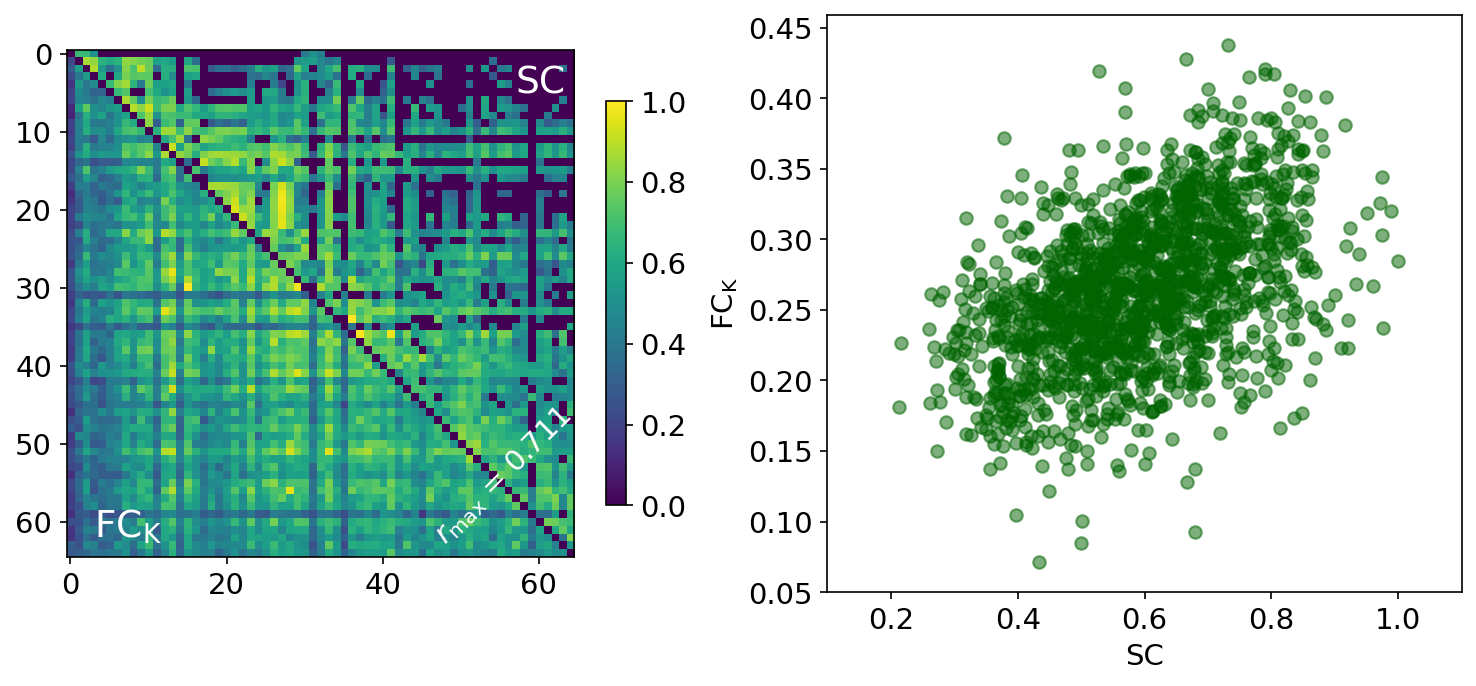

In [29]:
compared = np.tril(fc.standardize(fc.delete(FC_simulated, excluded))) + np.triu(fc.standardize(SC_truncated))

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

out0 = ax[0].imshow(compared, cmap="viridis")
ax[0].text(3,62,r"$\mathrm{FC}_{\mathrm{K}}$", color="white", fontsize=18)
ax[0].text(57,5,"SC", color="white",fontsize=18)
ax[0].text(48, 63, r"$r_{\mathrm{max}}$ = " + str(round(fc.correlate_matrices(fc.delete(FC_simulated,excluded), (SC_truncated)), 3)), color = 'white', rotation = 45, rotation_mode = 'anchor')
plt.colorbar(out0, ax=ax[0], shrink=0.7)
X = SC_truncated.flatten().reshape(-1, 1)
y = fc.delete(FC_simulated,excluded).flatten().reshape(-1, 1)
X_b = np.c_[np.ones((X.shape[0], 1)), X]
theta_best, residuals, rank, singular_values = np.linalg.lstsq(X_b, y, rcond=None)
intercept, slope = theta_best
ax[1].scatter(SC_truncated.flatten(), fc.delete(FC_simulated,excluded).flatten(), alpha=0.3, color="darKgreen")
#ax[1].plot([-1,2], [intercept-slope, intercept+slope*2], color="black", linestyle="--")
ax[1].set_xlim(0.1, np.max(SC_truncated)+0.1)
ax[1].set_ylim(0.05, np.max(FC_simulated)*1.05)
ax[1].set_xlabel("SC")
ax[1].set_ylabel(r"$\mathrm{FC}_{\mathrm{K}}$")

#plt.savefig("comparison_SC_vs_FCk.pdf")

plt.show()

#ax[1].hist(FC_simulated.flatten(),bins=30, color="blue", alpha=0.5, label=r"$\mathrm{FC}_{\mathrm{K}}$")
#ax[1].set_title("Weights distribution")
#ax[1].hist(FC_empirical.flatten(), bins=30, color="darkGreen", alpha=0.5, label="FC")
##ax[1].set_title("fConnectome")
#ax[1].legend()
#ax[1].set_yscale("log")
#plt.savefig("comparison_SC_vs_FC.pdf")
#plt.show()

### FC vs FCk

In [46]:
rVal = np.asarray(r_values_stack)
max_K_id = np.argmax(rVal) % rVal.shape[1]
max_w_id = np.argmax(rVal) // rVal.shape[1]
FC_simulated = FC_mean_stack[max_w_id][max_K_id]
print("Corrélation maximale avec FC : ", rVal[max_w_id,max_K_id])
print( "Couplage : ", K_vec[max_K_id] )

Corrélation maximale avec FC :  0.5745593912310096
Couplage :  2.4138


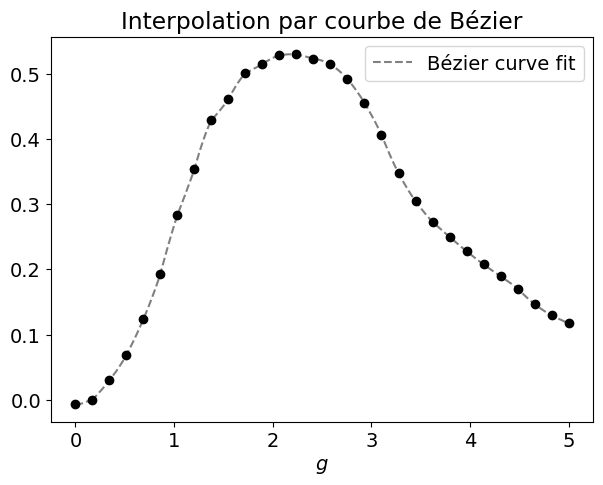

In [47]:
scatter_x = K_vec
scatter_y = np.mean(r_values_stack,axis=0)
points = np.column_stack((scatter_x, scatter_y))

n_points = len(points)
curves = []
# Premier segment
p0, p1 = points[0], points[1]
p2, p3 = fc.get_control_points(points[0], points[1], points[2])
curves.append(fc.bezier_curve(p0, p2, p3, p1, n_points = 1000))

# Segments intermédiaires
for i in range(1, n_points - 2):
    p0, p1 = points[i], points[i + 1]
    p2_prev, p3_prev = curves[-1][-2], curves[-1][-1]
    p2, p3 = fc.get_control_points(points[i], points[i + 1], points[i + 2])
    curves.append(fc.bezier_curve(p0, p2_prev, p2, p1))

# Dernier segment
p0, p1 = points[-2], points[-1]
p2_prev, p3_prev = curves[-1][-2], curves[-1][-1]
curves.append(fc.bezier_curve(p0, p2_prev, p3_prev, p1))

# Concaténation des segments
bezier_points = np.vstack(curves)

plt.figure(figsize=(7,5))
plt.scatter(scatter_x, scatter_y, color='black')
plt.plot(bezier_points[:, 0], bezier_points[:, 1], zorder=0,color='gray', linestyle="--", label='Bézier curve fit')
plt.legend()
plt.xlabel(r'$g$')
plt.title('Interpolation par courbe de Bézier')
plt.show()

FC_FC_optimal_K = bezier_points[bezier_max_K_id, 0]

# Fit d'un polynome là-dessus pis obtention du maximum
#start_i = 4
#end_i = 20

#max_polyfit = polyfit_maximum(K_vec[start_i:end_i], np.mean(r_values_stack, axis=0)[start_i:end_i], res_factor=20, deg=5, show=True)[0]
#print("Couplage de corrélation maximale déduit par ajustement polynomial ", max_polyfit)

In [48]:
# Fit de la Bézier pour obtention du maximum

bezier_max_K_id = np.argmax(bezier_points[:, 1])
print("Couplage de corrélation maximale déduit par ajustement de courbes de Bézier quadratiques :", bezier_points[bezier_max_K_id, 0])
FC_FC_optimal_K = bezier_points[bezier_max_K_id, 0]

Couplage de corrélation maximale déduit par ajustement de courbes de Bézier quadratiques : 2.1921563037358083


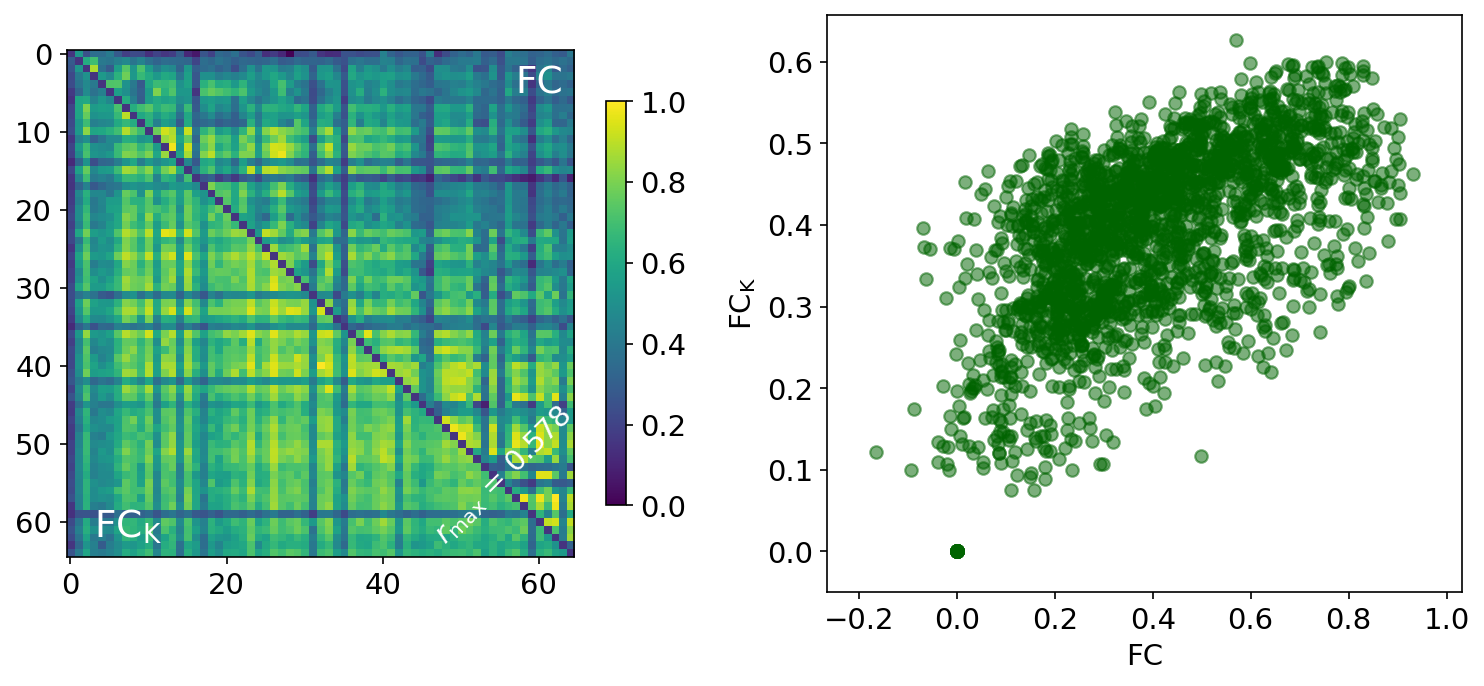

In [49]:
compared = np.tril(fc.standardize(fc.delete(FC_simulated,excluded))) + np.triu(fc.standardize(FC_empirical))

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

out0 = ax[0].imshow(compared, cmap="viridis")
ax[0].text(3,62,r"$\mathrm{FC}_{\mathrm{K}}$", color="white", fontsize=18)
ax[0].text(57,5,"FC", color="white",fontsize=18)
ax[0].text(48,63,r"$r_{\mathrm{max}}$ = " + str(round(fc.correlate_matrices(fc.delete(FC_simulated,excluded), FC_empirical) , 3)), color = 'white', rotation = 45, rotation_mode = 'anchor')
plt.colorbar(out0, ax=ax[0], shrink=0.7)
X = FC_empirical.flatten().reshape(-1, 1)
y = fc.delete(FC_simulated,excluded).flatten().reshape(-1, 1)
X_b = np.c_[np.ones((X.shape[0], 1)), X]
theta_best, residuals, rank, singular_values = np.linalg.lstsq(X_b, y, rcond=None)
intercept, slope = theta_best
ax[1].scatter(FC_empirical.flatten(), fc.delete(FC_simulated,excluded).flatten(), alpha=0.3, color="darKgreen")
#ax[1].plot([-1,2], [intercept-slope, intercept+slope*2], color="black", linestyle="--")
ax[1].set_xlim(np.min(FC_empirical)-0.1, np.max(FC_empirical)+0.1)
ax[1].set_ylim(np.min(FC_simulated)-0.05, np.max(FC_simulated)*1.05)
ax[1].set_xlabel("FC")
ax[1].set_ylabel(r"$\mathrm{FC}_{\mathrm{K}}$")

#plt.savefig("comparison_FC_vs_FCk.pdf")

plt.show()

#ax[1].hist(FC_simulated.flatten(),bins=30, color="blue", alpha=0.5, label=r"$\mathrm{FC}_{\mathrm{K}}$")
#ax[1].set_title("Weights distribution")
#ax[1].hist(FC_empirical.flatten(), bins=30, color="darkGreen", alpha=0.5, label="FC")
##ax[1].set_title("fConnectome")
#ax[1].legend()
#ax[1].set_yscale("log")
#plt.savefig("comparison_SC_vs_FC.pdf")
#plt.show()

## Capping of correlation value according to number of matrices averaged per FC_K
Juste pour le jeu de données complet qui contient toutes les matrices simulées.

In [ ]:

FC_shape = data[0]['FC'][max_K_id][0].shape

matrices_coherences_stack_optimum = []

for i in tqdm(range(wR_vec.shape[0])):
    #Calcul des matrices FC moyennes pour les N simulations
    matrices_coherences_stack_optimum.append(data[i]['FC'][max_K_id])

win_size = 100

FCs_optimum_all = np.asarray(matrices_coherences_stack_optimum).reshape( -1, FC_shape[0], FC_shape[1] )
r_values_stack = []
for j in range(FCs_optimum_all.shape[0] // win_size):
    r_values = []
    acc_FC = np.zeros(FC_shape)
    for k in range(win_size):
        acc_FC += FCs_optimum_all[k+j]
        r_values.append(fc.correlate_matrices(fc.delete(acc_FC, excluded), FC_empirical, choice=False))
    r_values_stack.append(r_values)

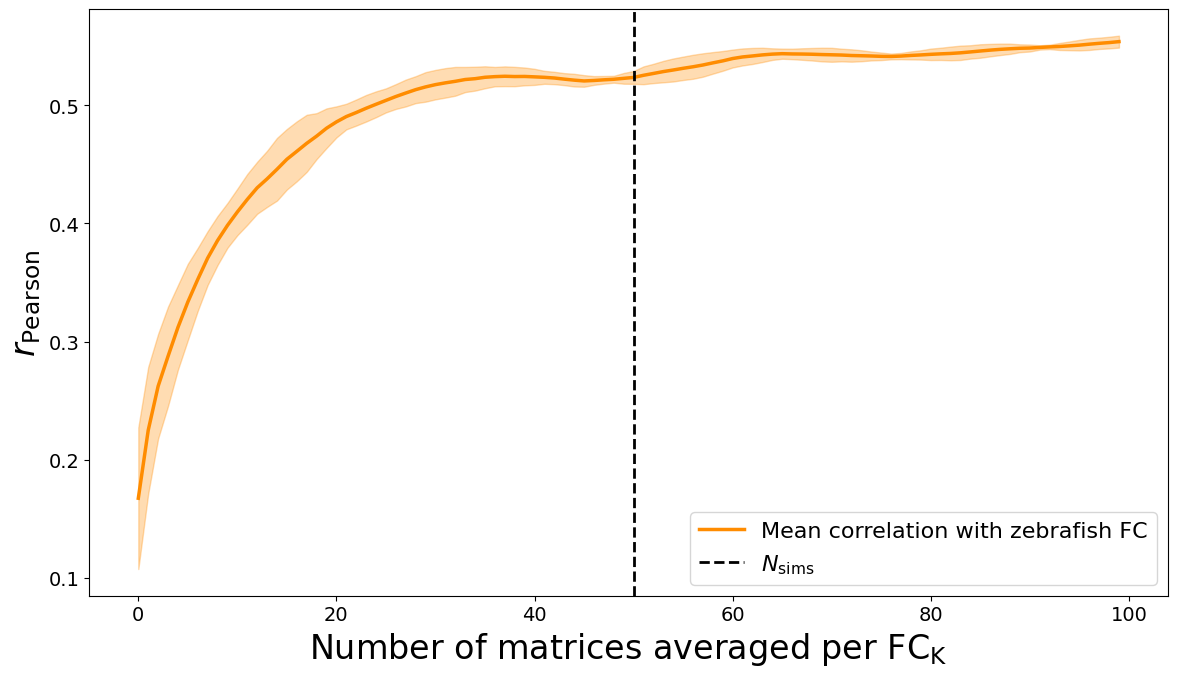

In [47]:
r_values_mean = np.mean(r_values_stack, axis=0)
r_values_std = np.std(r_values_stack, axis=0)
nb_of_matrices_axis = np.arange(win_size)

fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.plot(nb_of_matrices_axis, r_values_mean, color="darkOrange", linewidth=2.5,label="Mean correlation with zebrafish FC")
ax.fill_between(nb_of_matrices_axis, r_values_mean-r_values_std, r_values_mean+r_values_std, color="darkOrange", alpha=0.3)
ax.set_xlabel("Number of matrices averaged per " + r"$\mathrm{FC}_{\mathrm{K}}$", fontsize=24)
ax.set_ylabel(r"$r_{\mathrm{Pearson}}$", fontsize=24)
ax.axvline(50, linestyle="--", color="black", linewidth=2, label=r"$N_{\mathrm{sims}}$")
ax.legend(loc="lower right", fontsize=16)
plt.savefig("plafonnage_corr_kuramoto.pdf")
#plt.savefig("plafonnage_corr_kuramoto.png")
plt.tight_layout()
plt.show()

## Distribution at optimal configuration for 
On simule plusieurs FC synthétiques à la valeur de gain maximisant le lien structure-fonction. 


In [68]:
# Nombre de simulations par FC synthétique
N_sim = 50
# Nombre de FC synthétiques simulées
FC_num = 500
random_ids_for_null_models_drawn = np.random.randint(0,FC_num-1,FC_num)


# Nombre de noeuds (on en exclut 5 par après)
nodes_n = 70

# Temps
#t_end = 100 
#rtol = 1e-8 # tolérance d'erreur lors de l'intégration numérique
#atol = 1e-8 # tolérance d'erreur lors de l'intégration numérique

t_i = 0
t_f = 100
dt = 0.01
t_vec = np.linspace(t_i, t_f, int(t_f/dt) )

# Couplage
K_max = SC_FC_optimal_K 
K_vec = np.ones(FC_num) * np.round(K_max, 4)

# Initialisation des fréquences propres
omega_static = True # C'est ici qu'on initialise les fréquences propres des oscillateurs. On spécifie l'intervalle de distribution uniforme plus bas.
omega_static_interv = [0,2]
omega_sweep_n = 1
omega_normal = False
omega_unif = True


# Type de FC
phase_coherence = True # Par défaut : matrice de corrélation du sinus des phases
# Aucun balayage, on ne fait que plusieurs paquets de simulations pour une même configuration de couplage (et distribution fréquentielle constante)
if omega_static:
    omega_center_vec = np.ones(omega_sweep_n)*(omega_static_interv[1]-omega_static_interv[0])/2
    omega_radius_vec = np.copy(omega_center_vec)
    

# Balayage de la valeur centrale (de la valeur max à sa moitié) et du rayon de la distribution uniforme (majoration par valeur max)
if omega_static:
    print("Bornes de la distribution statique des fréquences naturelles : ", omega_static_interv)

Bornes de la distribution statique des fréquences naturelles :  [0, 2]


### SC injected

In [70]:
sim_id = len(fc.identify_files(top_dir+"/Data/sims", keywords=["kuramotoDist"]))
sim_folder = top_dir + "/Data/sims/" + "kuramotoDist_sim_{}".format(sim_id)
fc.create_folder(sim_folder)

sims_dict = {} # On réinitialise le dictionnaire qui contient les informations de la simulation
#sims_dict["omega_unif"] = omega_unif # Type de distribution des fréquences naturelles
#sims_dict["omega_unif_max"] = omega_unif_max
#sims_dict["omega_ponct"] = omega_ponctual # Type de distribution des fréquences naturelles
#sims_dict["omega_unif_fixC"] = omega_unif_fixedCtr # Type de distribution des fréquences naturelles
#sims_dict["omega_norm"] = omega_normal
sims_dict["omega_static"] = omega_static

if omega_normal:
    sims_dict["omega_std"] = omega_std_vec[0] # Écart-type de la distribution de fréquences naturelles
    sims_dict["omega_ctr"] = omega_mean # Valeur centrale de la distribution de fréquences naturelles
elif omega_unif or omega_ponctual or omega_unif_max or omega_static:
    sims_dict["omega_r"] = omega_radius_vec[0] # Rayon de la distribution
    sims_dict["omega_ctr"] = omega_center_vec[0] # Valeur centrale de la distribution de fréquences naturelles

sims_dict["info"] = "Coherence FC : " + str(phase_coherence)
sims_dict["correls"] = []
sims_dict["K"] = K_vec # Valeurs de couplage balayés
sims_dict["t"] = (t_i, t_f) # Intervalle de temps
for j,K_ in tqdm(enumerate(K_vec)):

    FCsim_stack = []

    for i in range(N_sim):
        
        K = K_ * SC # On injecte "à sec" le SC dans la matrice de couplage
        
        if omega_normal: # réinitialisation des fréquences naturelles
            W = np.abs(np.random.normal(sims_dict["omega_ctr"], sims_dict["omega_std"], nodes_n))
        else:
            W = np.random.uniform(sims_dict["omega_ctr"]-sims_dict["omega_r"], sims_dict["omega_ctr"]+sims_dict["omega_r"], nodes_n)

        #omegas_stack.append(W)
        
        X_initial = np.random.uniform(0, 2*np.pi, nodes_n) # réinitialisation des phases de départ
        solution = sp.integrate.solve_ivp(kuramoto_deriv, t_span=(t_i,t_f), y0=X_initial, args=(W,K), t_eval=t_vec)#, atol=atol, rtol=rtol, method="RK45").y

        # On génère une FC synthétique
        if phase_coherence:
            FC_sim = fc.compute_phase_coherence_matrix(solution)
        else:
            sin_series = np.sin(solution) # TR : fonction sinus
            FC_sim = fc.compute_correlation_matrix(sin_series)
            
        FCsim_stack.append(FC_sim)

    # Ajout au dictionnaire
    corr_1 = fc.correlate_matrices(fc.delete(np.mean(FCsim_stack,axis=0), excluded), SC_truncated)
    corr_2 = fc.correlate_matrices(fc.delete(np.mean(FCsim_stack,axis=0), excluded), FC_empirical)
    sims_dict["correls"].append([ corr_1, corr_2] )

# Enregistrement des données sous forme de dictionnaire
sim_iteration = len(fc.identify_files(sim_folder, keywords=["kuramoto"]))
fc.save_hdf5(sim_folder +"/{}_".format(fc.fill_index(sim_iteration)) + "kuramoto(SC).hdf5", sims_dict)
print("Enregistrement" )



0it [00:00, ?it/s]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /home/arleg/Documents/CERVO/projetRNN/fC_sim/functions.py (93)

File "functions.py", line 93:
def fact(x):
    <source elided>

@njit
^ 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'scipy.integrate._ivp.ivp.OdeResult'>


### SCCM null model of SC injected

In [67]:

sims_dict = {} # On réinitialise le dictionnaire qui contient les informations de la simulation
sims_dict["omega_unif"] = omega_unif # Type de distribution des fréquences naturelles
sims_dict["omega_unif_max"] = omega_unif_max
sims_dict["omega_ponct"] = omega_ponctual # Type de distribution des fréquences naturelles
sims_dict["omega_unif_fixC"] = omega_unif_fixedCtr # Type de distribution des fréquences naturelles
sims_dict["omega_norm"] = omega_normal
sims_dict["omega_static"] = omega_static

if omega_normal:
    sims_dict["omega_std"] = omega_std_vec[0] # Écart-type de la distribution de fréquences naturelles
    sims_dict["omega_ctr"] = omega_mean # Valeur centrale de la distribution de fréquences naturelles
elif omega_unif or omega_ponctual or omega_unif_max or omega_static:
    sims_dict["omega_r"] = omega_radius_vec[0] # Rayon de la distribution
    sims_dict["omega_ctr"] = omega_center_vec[0] # Valeur centrale de la distribution de fréquences naturelles

sims_dict["info"] = "Coherence FC : " + str(phase_coherence)
sims_dict["correls"] = []
sims_dict["K"] = K_vec # Valeurs de couplage balayés
sims_dict["dt"] = dt # Pas de temps d'intégration numérique
sims_dict["t"] = (t_i, t_f) # Intervalle de temps
for j,K_ in tqdm(enumerate(K_vec)):

    FCsim_stack = []
    omegas_stack = []
    orders_stack = []

    for i in range(N_sim):
        
        K = K_ * SC_sccm[random_ids_for_null_models_drawn[j]] # On injecte "à sec" le SC dans la matrice de couplage
        
        if omega_normal: # réinitialisation des fréquences naturelles
            W = np.abs(np.random.normal(sims_dict["omega_ctr"], sims_dict["omega_std"], nodes_n))
        else:
            W = np.random.uniform(sims_dict["omega_ctr"]-sims_dict["omega_r"], sims_dict["omega_ctr"]+sims_dict["omega_r"], nodes_n)

        omegas_stack.append(W)
        
        X_initial = np.random.uniform(0, 2*np.pi, nodes_n) # réinitialisation des phases de départ
        solution = sp.integrate.solve_ivp(kuramoto_deriv, t_span=(t_i,t_f), y0=X_initial, args=(W,K), atol=atol, rtol=rtol, method="RK45").y

        # On génère une FC synthétique
        if phase_coherence:
            FC_sim = fc.compute_phase_coherence_matrix(solution)
        else:
            sin_series = np.sin(solution) # TR : fonction sinus
            FC_sim = fc.compute_correlation_matrix(sin_series)
            
        FCsim_stack.append(FC_sim)

    # Ajout au dictionnaire
    corr_1 = fc.correlate_matrices(fc.delete(np.mean(FCsim_stack,axis=0), excluded), SC_truncated)
    corr_2 = fc.correlate_matrices(fc.delete(np.mean(FCsim_stack,axis=0), excluded), FC_empirical)
    sims_dict["correls"].append([ corr_1, corr_2] )

# Enregistrement des données sous forme de dictionnaire
sim_iteration = len(fc.identify_files(sim_folder, keywords=["kuramoto"]))
fc.save_hdf5(sim_folder +"/{}_".format(fc.fill_index(sim_iteration)) + "kuramoto(SCCM).hdf5", sims_dict)
print("Enregistrement" )



200it [36:53, 11.07s/it]

Enregistrement


### CM null model of SC injected

In [68]:

sims_dict = {} # On réinitialise le dictionnaire qui contient les informations de la simulation
sims_dict["omega_unif"] = omega_unif # Type de distribution des fréquences naturelles
sims_dict["omega_unif_max"] = omega_unif_max
sims_dict["omega_ponct"] = omega_ponctual # Type de distribution des fréquences naturelles
sims_dict["omega_unif_fixC"] = omega_unif_fixedCtr # Type de distribution des fréquences naturelles
sims_dict["omega_norm"] = omega_normal
sims_dict["omega_static"] = omega_static

if omega_normal:
    sims_dict["omega_std"] = omega_std_vec[0] # Écart-type de la distribution de fréquences naturelles
    sims_dict["omega_ctr"] = omega_mean # Valeur centrale de la distribution de fréquences naturelles
elif omega_unif or omega_ponctual or omega_unif_max or omega_static:
    sims_dict["omega_r"] = omega_radius_vec[0] # Rayon de la distribution
    sims_dict["omega_ctr"] = omega_center_vec[0] # Valeur centrale de la distribution de fréquences naturelles

sims_dict["info"] = "Coherence FC : " + str(phase_coherence)
sims_dict["correls"] = []
sims_dict["K"] = K_vec # Valeurs de couplage balayés
sims_dict["dt"] = dt # Pas de temps d'intégration numérique
sims_dict["t"] = (t_i, t_f) # Intervalle de temps
for j,K_ in tqdm(enumerate(K_vec)):

    FCsim_stack = []
    omegas_stack = []
    orders_stack = []

    for i in range(N_sim):
        
        K = K_ * SC_cm[random_ids_for_null_models_drawn[j]] # On injecte "à sec" le SC dans la matrice de couplage
        
        if omega_normal: # réinitialisation des fréquences naturelles
            W = np.abs(np.random.normal(sims_dict["omega_ctr"], sims_dict["omega_std"], nodes_n))
        else:
            W = np.random.uniform(sims_dict["omega_ctr"]-sims_dict["omega_r"], sims_dict["omega_ctr"]+sims_dict["omega_r"], nodes_n)

        omegas_stack.append(W)
        
        X_initial = np.random.uniform(0, 2*np.pi, nodes_n) # réinitialisation des phases de départ
        solution = sp.integrate.solve_ivp(kuramoto_deriv, t_span=(t_i,t_f), y0=X_initial, args=(W,K), atol=atol, rtol=rtol, method="RK45").y

        # On génère une FC synthétique
        if phase_coherence:
            FC_sim = fc.compute_phase_coherence_matrix(solution)
        else:
            sin_series = np.sin(solution) # TR : fonction sinus
            FC_sim = fc.compute_correlation_matrix(sin_series)
            
        FCsim_stack.append(FC_sim)

    # Ajout au dictionnaire
    corr_1 = fc.correlate_matrices(fc.delete(np.mean(FCsim_stack,axis=0), excluded), SC_truncated)
    corr_2 = fc.correlate_matrices(fc.delete(np.mean(FCsim_stack,axis=0), excluded), FC_empirical)
    sims_dict["correls"].append([ corr_1, corr_2] )

# Enregistrement des données sous forme de dictionnaire
sim_iteration = len(fc.identify_files(sim_folder, keywords=["kuramoto"]))
fc.save_hdf5(sim_folder +"/{}_".format(fc.fill_index(sim_iteration)) + "kuramoto(CM).hdf5", sims_dict)
print("Enregistrement")



200it [36:10, 10.85s/it]

Enregistrement


### Comparison of correlations distribution

In [31]:
sim_id = 1
sim_folder = top_dir + "/Data/sims/" + "kuramotoDist_sim_{}".format(sim_id)
print(sim_folder)

/home/arleg/Documents/CERVO/projetRNN/fC_sim/Data/sims/kuramotoDist_sim_1


In [32]:
# On importe les données de la simulation
data_files = fc.identify_files(sim_folder, keywords="hdf5")
data_files = sorted(data_files)

data = []
for data_file in tqdm(data_files):
    data.append(fc.load_hdf5(sim_folder+"/"+data_file))

print(data[0].keys())

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 185.23it/s]

dict_keys(['K', 'correls', 'info', 'omega_ctr', 'omega_norm', 'omega_ponct', 'omega_r', 'omega_static', 'omega_unif', 'omega_unif_fixC', 'omega_unif_max', 't'])


Petit commentaire : les prob qui ont le plus de sens sont celles qui correspondent à la valeur moyenne des sim sur SC ou la valeur optimale (max) des sim sur SC, pas la valeur FC empirique. On écrit généralement \alpha seulement pour des seuils critiques. Ici, tes prob sont plus des valeurs p.
Par contre, je pense que pour ton analyse, on devrait plutôt faire un t-test de Welch stats.ttest_ind(data1, data2, equal_var=False)  pour montrer que les différences de corr moyennes sont significatives. On pourrait aussi ajouter (SM) un test des permutations pour déterminer si la diff entre le max de data1 et max de data2 est significative, démontrant ainsi qu'il est très peu probable d'obtenir des corr maximales aussi élevées avec des réseaux pigés au hasard dans un modèle nul.

In [39]:
np.save("kuramoto_distr_SC.npy", data[0]["correls"][:,0]) # Correls with SC injected
np.save("kuramoto_distr_SCCM.npy", data[1]["correls"][:,0]) # Correls with SCCM injected
np.save("kuramoto_distr_CM.npy", data[2]["correls"][:,0]) # Correls with CM injected

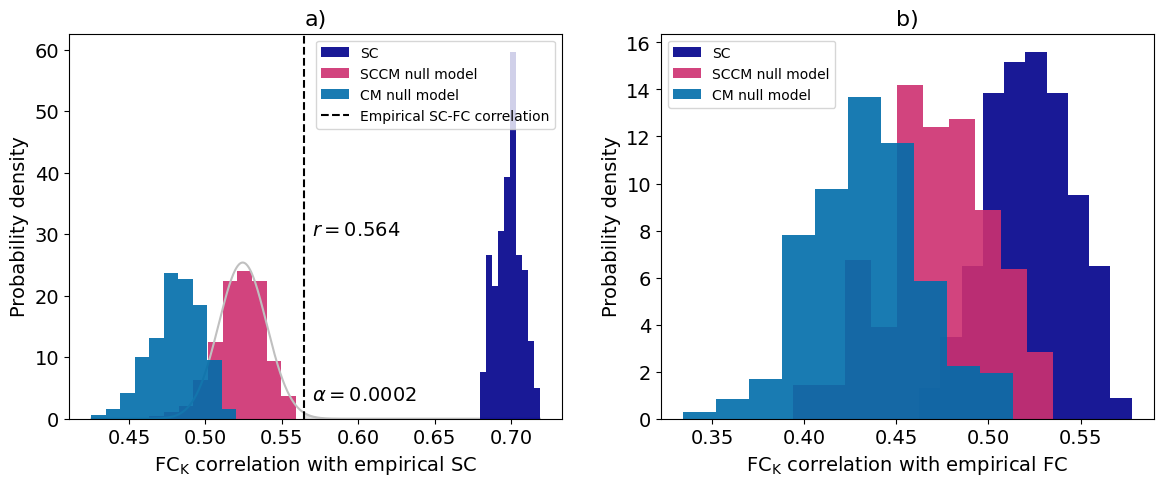

In [64]:
bins_n = 10
fig,ax = plt.subplots(1,2, figsize=(14,5))
out1 = ax[0].hist(data[0]["correls"][:,0],zorder=3, density=True, bins=bins_n,label="SC", color="darkBlue", alpha=0.9)
out2 = ax[0].hist(data[1]["correls"][:,0], bins=bins_n, density=True, label="SCCM null model", color="#cd3070ff", alpha=0.9)
x_window = (np.min(np.concatenate((out1[1],out2[1],out3[1]))),np.max(np.concatenate((out1[1],out2[1],out3[1]))))
y_window = (np.min(np.concatenate((out1[0],out2[0],out3[0]))),np.max(np.concatenate((out1[0],out2[0],out3[0])))) 
fit_params, cov = sp.optimize.curve_fit(fc.gaussienne, out2[1][:-1] + np.diff(out2[1])/2, out2[0], (np.max(out2[0]),100, 0.5)) 
fit_y = fc.gaussienne(np.linspace(x_window[0],x_window[1],1000), fit_params[0], fit_params[1], fit_params[2]) 
ax[0].plot(np.linspace(x_window[0],x_window[1],1000), fit_y, color="silver", zorder=1) 
out3 = ax[0].hist(data[2]["correls"][:,0], bins=bins_n, density=True, label="CM null model", color="#006daaff", alpha=0.9)
ax[0].set_xlabel(r"$\mathrm{FC}_{\mathrm{K}}$ correlation with empirical SC")
ax[0].set_ylabel("Probability density")
empirical_SCFC_correlation = fc.correlate_matrices(FC_empirical, SC_truncated)
overlap_x = np.linspace(empirical_SCFC_correlation,x_window[1],100)
ax[0].fill_between(overlap_x,overlap_x*0,fc.gaussienne(overlap_x, fit_params[0], fit_params[1], fit_params[2]), color="silver", zorder=1, alpha=0.5) 
alpha = 1-sp.stats.norm.cdf(np.abs(empirical_SCFC_correlation - fit_params[2])/(1/(2*np.sqrt(fit_params[1]))))
ax[0].axvline(empirical_SCFC_correlation, linestyle="--", color="black", label="Empirical SC-FC correlation")
ax[0].text(empirical_SCFC_correlation*1.01, y_window[1]*0.5, r"$r=$"+str(np.round(empirical_SCFC_correlation,3)))
ax[0].text(empirical_SCFC_correlation*1.01, y_window[1]*0.05, r"$\alpha=$"+str(np.round(alpha,4)))
ax[0].set_title("a)", fontsize=16)
ax[0].legend(fontsize=10)
ax[1].hist(data[0]["correls"][:,1],density=True, bins=bins_n, label="SC", color="darkBlue", alpha=0.9)
ax[1].hist(data[1]["correls"][:,1], density=True, bins=bins_n, label="SCCM null model", color="#cd3070ff", alpha=0.9)
ax[1].hist(data[2]["correls"][:,1], density=True, bins=bins_n, label="CM null model", color="#006daaff", alpha=0.9)
ax[1].set_xlabel(r"$\mathrm{FC}_{\mathrm{K}}$ correlation with empirical FC")
ax[1].set_ylabel("Probability density")
ax[1].set_title("b)", fontsize=16)
ax[1].legend(fontsize=10)
plt.savefig("kuramoto_distributions_FCnum=200.pdf")
plt.show()
